In [ ]:
import pandas as pd
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import numpy as np
from keras.models import load_model
import time 
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from sklearn.preprocessing import MinMaxScaler

NUM_OF_CLASSES = 3

def prepare_train_test_dataset():
    train_data = pd.read_csv("train_data.csv")
    train_labels = pd.read_csv("train_labels.csv")
    test_data = pd.read_csv("test_data.csv")
    test_labels = pd.read_csv("test_labels.csv")
    whole_data = pd.concat([train_data, test_data])
    min_max_scaler = MinMaxScaler().fit(whole_data)
    train_data = min_max_scaler.transform(train_data)
    test_data = min_max_scaler.transform(test_data)
    train_labels = train_labels.status.astype('category').cat.codes.to_numpy()
    # train_labels = to_categorical(train_labels,NUM_OF_CLASSES)
    test_labels = test_labels.status.astype('category').cat.codes.to_numpy()
    # test_labels = to_categorical(test_labels,NUM_OF_CLASSES)
    return (train_data, train_labels),(test_data, test_labels)

def plot_history(history, epochs_size):
    loss_list = []
    accuracy_list = []
    history_keys = history.history.keys()
    for key in history_keys:
        if "loss" in key:
            loss_list.append(key)
        
        elif "acc" in key:
            accuracy_list.append(key)
        
        elif "accuracy" in key:
            accuracy_list.append(key)

    # print(loss_list)
    # print(accuracy_list)
    
    colors = list(mcolors.BASE_COLORS.keys())
    epochs = range(1, (epochs_size+1))
    fig, ax = plt.subplots(2, figsize=(20, 8))

    for key,color in zip(loss_list, colors):
        ax[0].plot(epochs ,history.history[key], str(color), label=str(key))

    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("%")
    ax[0].set_title("Loss of Model:")
    ax[0].legend()

    for key,color in zip(accuracy_list, colors):
        ax[1].plot(epochs, history.history[key], str(color), label=str(key))
        
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("%")
    ax[1].set_title("Accuracy of Model:")
    ax[1].legend()

    # set the spacing between subplots
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.8)

    plt.show()

    fig.savefig("testfigure.pgf", backend="pgf", dpi=1000, bbox_inches="tight")

def append_value(dict_obj, key, value):
    # Check if key exist in dict or not
    if key in dict_obj:
        # Key exist in dict.
        # Check if type of value of key is list or not
        if not isinstance(dict_obj[key], list):
            # If type is not list then make it list
            dict_obj[key] = [dict_obj[key]]
        # Append the value in list
        dict_obj[key].append(value)
    else:
        # As key is not in dict,
        # so, add key-value pair
        dict_obj[key] = value

def print_best_history(history, training_time):
    history_dict = {}
    fnn_history_keys = history.history.keys()
    params_index = np.argmax(history.history["val_acc"])
    for key in fnn_history_keys:
        append_value(history_dict, key, history.history[key][params_index])
    history_dict["training_time"] = training_time
    print(history_dict)
    return history_dict

# Evaluate the model on the test data using `evaluate`
def evaluate_model(model, test_data, test_labels):
    best_fnn = load_model(model.name + ".h5")
    print("Evaluate on test data:")
    test_start = time.time()
    results = best_fnn.evaluate(test_data, test_labels, batch_size=128)
    testing_time = time.time() - test_start
    print("test loss, test acc:", results)
    return results[0], results[1], testing_time

# Compile and Train model
def train_model(model,train_data,train_labels, epochs):
    model_checkpoint_callback_fnn = ModelCheckpoint(
    filepath=(model.name + ".h5"),
    save_weights_only=False,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

    model.compile(optimizer=Adam(), loss=SparseCategoricalCrossentropy(from_logits=True), metrics=["acc"])

    training_start = time.time()
    model_history = model.fit(train_data, train_labels, epochs=epochs, validation_split=0.1, callbacks=model_checkpoint_callback_fnn)
    training_time = time.time() - training_start
    return model, model_history, training_time

In [8]:
(train_data, train_labels),(test_data, test_labels) = prepare_train_test_dataset()
# conv_train_data = train_data.to_numpy()

In [7]:
from keras.models import Model
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Input
import tensorflow as tf
from keras import Sequential
from keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model

fnn = Sequential([
    Input(shape=(4,), name="input-layer"),
    Dense(64, activation="relu"),
    Dense(128, activation="relu"),
    Dense(256, activation="relu"),
    Dense(128, activation="relu"),
    Dense(16, activation="relu"),
    Dense(3, name="output_layer")
],name="fnn_model")

plot_model(fnn, "fnn_architecture.pdf", show_shapes=True, show_layer_names=True)

In [9]:
from keras.models import Model
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Input
import tensorflow as tf
from keras import Sequential
from keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from keras.optimizers import Adam

EPOCHS = 80

fnn = Sequential([
    Input(shape=(4,), name="input-layer"),
    Dense(64, activation="relu"),
    Dense(128, activation="relu"),
    Dense(256, activation="relu"),
    Dense(128, activation="relu"),
    Dense(16, activation="relu"),
    Dense(3, name="output_layer")
],name="fnn_model")

fnn_model, fnn_history, training_time = train_model(fnn, train_data, train_labels, EPOCHS)

Epoch 1/80
2168/2168 [==============================] - 6s 2ms/step - loss: 0.2871 - acc: 0.8833 - val_loss: 0.1933 - val_acc: 0.9237
Epoch 2/80
2168/2168 [==============================] - 5s 2ms/step - loss: 0.1682 - acc: 0.9297 - val_loss: 0.1606 - val_acc: 0.9349
Epoch 3/80
2168/2168 [==============================] - 5s 2ms/step - loss: 0.1550 - acc: 0.9345 - val_loss: 0.1280 - val_acc: 0.9515
Epoch 4/80
2168/2168 [==============================] - 6s 3ms/step - loss: 0.1470 - acc: 0.9383 - val_loss: 0.1296 - val_acc: 0.9450
Epoch 5/80
2168/2168 [==============================] - 5s 3ms/step - loss: 0.1414 - acc: 0.9406 - val_loss: 0.1263 - val_acc: 0.9494
Epoch 6/80
2168/2168 [==============================] - 6s 3ms/step - loss: 0.1351 - acc: 0.9427 - val_loss: 0.1229 - val_acc: 0.9460
Epoch 7/80
2168/2168 [==============================] - 6s 3ms/step - loss: 0.1346 - acc: 0.9433 - val_loss: 0.1301 - val_acc: 0.9462
Epoch 8/80
2168/2168 [==============================] - 5s 3ms

{'loss': 0.028389209881424904, 'acc': 0.9896498322486877, 'val_loss': 0.013195228762924671, 'val_acc': 0.9959781765937805, 'training_time': 439.3498682975769}


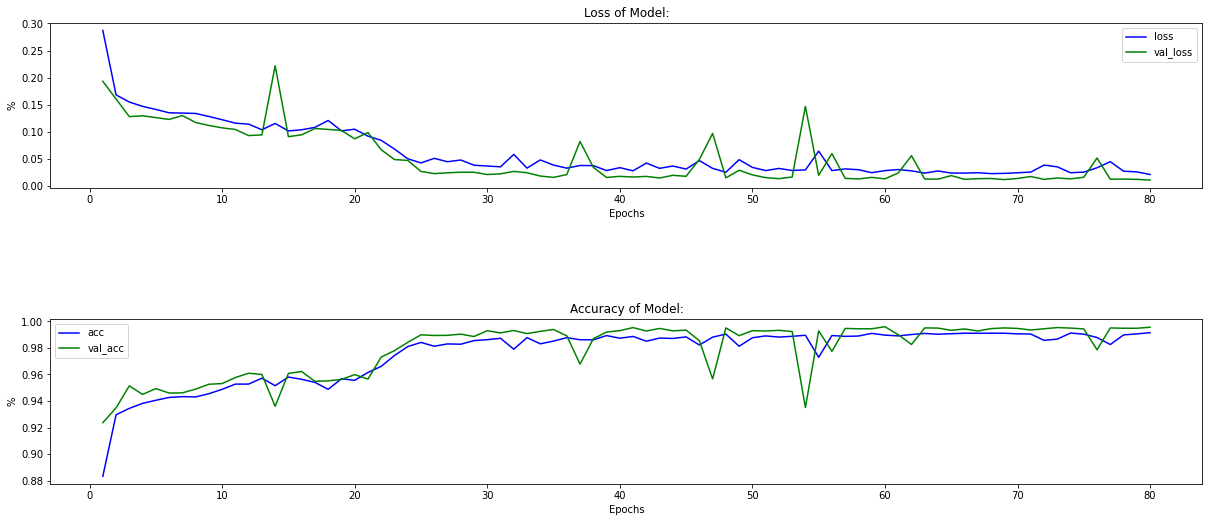

In [10]:
history_dict = print_best_history(fnn_history, training_time)
plot_history(history=fnn_history, epochs_size=EPOCHS)

In [11]:
loss, accuracy, testing_time = evaluate_model(model=fnn_model, test_data=test_data, test_labels=test_labels)
print("Time for testing: " + str(testing_time))

Evaluate on test data:
151/151 [==============================] - 0s 2ms/step - loss: 0.0285 - acc: 0.9947
test loss, test acc: [0.028490476310253143, 0.9947068095207214]
Time for testing: 0.42303466796875


In [6]:
from keras import Sequential 
from keras.layers import Conv1D, Dense, Flatten, Input
from keras.utils.vis_utils import plot_model
conv_fnn = Sequential([
    Input(shape=(4,1), name="input-layer"),
    Conv1D(filters=9, kernel_size=2, activation="relu"),
    Dense(32, activation="relu"),
    Dense(32, activation="relu"),
    Dense(16,activation="relu"),
    Flatten(),
    Dense(3)
], name="conv_fnn_model")
plot_model(conv_fnn, "conv_fnn_architecture.pdf", show_shapes=True, show_layer_names=True)

In [12]:
from keras.layers import Conv1D, Dense, Flatten

conv_fnn = Sequential([
    Input(shape=(4,1), name="input-layer"),
    Conv1D(filters=9, kernel_size=2, activation="relu"),
    Dense(32, activation="relu"),
    Dense(32, activation="relu"),
    Dense(16,activation="relu"),
    Flatten(),
    Dense(3)
], name="conv_fnn_model")

model_checkpoint_callback_conv_fnn = ModelCheckpoint(
    filepath=(conv_fnn.name + ".h5"),
    save_weights_only=False,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

# conv_train_data = train_data.reshape(77079,4,1)

conv_fnn_model, conv_fnn_history, training_time = train_model(conv_fnn, train_data, train_labels, EPOCHS)

Epoch 1/80
2168/2168 [==============================] - 4s 2ms/step - loss: 0.5369 - acc: 0.7902 - val_loss: 0.2821 - val_acc: 0.9049
Epoch 2/80
2168/2168 [==============================] - 4s 2ms/step - loss: 0.2579 - acc: 0.8984 - val_loss: 0.2141 - val_acc: 0.9231
Epoch 3/80
2168/2168 [==============================] - 4s 2ms/step - loss: 0.2274 - acc: 0.9106 - val_loss: 0.2312 - val_acc: 0.9223
Epoch 4/80
2168/2168 [==============================] - 4s 2ms/step - loss: 0.2135 - acc: 0.9159 - val_loss: 0.1868 - val_acc: 0.9285
Epoch 5/80
2168/2168 [==============================] - 4s 2ms/step - loss: 0.2066 - acc: 0.9182 - val_loss: 0.1824 - val_acc: 0.9296
Epoch 6/80
2168/2168 [==============================] - 4s 2ms/step - loss: 0.2025 - acc: 0.9201 - val_loss: 0.1771 - val_acc: 0.9380
Epoch 7/80
2168/2168 [==============================] - 4s 2ms/step - loss: 0.1995 - acc: 0.9227 - val_loss: 0.1755 - val_acc: 0.9353
Epoch 8/80
2168/2168 [==============================] - 4s 2ms

{'loss': 0.09474881738424301, 'acc': 0.9645673036575317, 'val_loss': 0.08854151517152786, 'val_acc': 0.969771683216095, 'training_time': 315.4803647994995}


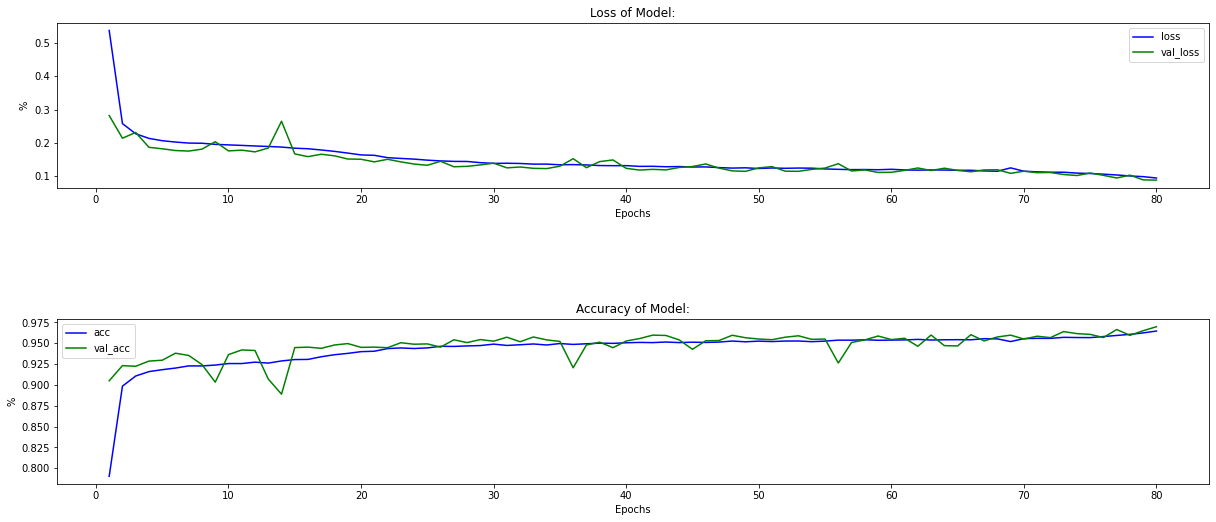

In [13]:
history_dict = print_best_history(conv_fnn_history, training_time)
plot_history(history=conv_fnn_history, epochs_size=EPOCHS)

In [14]:
loss, accuracy, testing_time = evaluate_model(model=conv_fnn_model, test_data=test_data, test_labels=test_labels)
print("Time for testing: " + str(testing_time))

Evaluate on test data:
151/151 [==============================] - 0s 1ms/step - loss: 0.0872 - acc: 0.9680
test loss, test acc: [0.0871860608458519, 0.9680331945419312]
Time for testing: 0.4098067283630371


# Result: FNN is the winnner! 